## Run this notebook

You can launch this notebook in the US GHG Center JupyterHub by clicking the link below.

[Launch in the US GHG Center JupyterHub (requires access)](https://hub.ghg.center/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2FUS-GHG-Center%2Fghgc-docs&urlpath=lab%2Ftree%2Fghgc-docs%2Fuser_data_notebooks%2Flpjeosim-wetlandch4-monthgrid-v2_User_Notebook.ipynb&branch=main)
   

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the Wetland Methane Emissions, LPJ-EOSIM Model data product.
2. Pass the STAC item into the raster API `/collections/{collection_id}/items/{item_id}/tilejson.json` endpoint.
3. Using `folium.plugins.DualMap`, visualize two tiles (side-by-side), allowing time point comparison.
4. After the visualization, perform zonal statistics for a given polygon.
   

## About the Data

Methane (CH₄) emissions from vegetated wetlands are estimated to be the largest natural source of methane in the global CH₄ budget, contributing to roughly one third of the total of natural and anthropogenic emissions. Wetland CH₄ is produced by microbes breaking down organic matter in the oxygen deprived environment of inundated soils. Due to limited data availability, the details of the role of wetland CH₄ emissions have thus far been underrepresented. Using the Earth Observation SIMulator version (LPJ-EOSIM) of the Lund-Potsdam-Jena Dynamic Global Vegetation Model (LPJ-DGVM) global CH₄ emissions from wetlands are estimated at 0.5° x 0.5 degree spatial resolution. By simulating wetland extent and using characteristics of inundated areas, such as wetland soil moisture, temperature, and carbon content, the model provides estimates of CH₄ quantities emitted into the atmosphere. This dataset shows concentrated methane sources from tropical and high latitude ecosystems. The LPJ-EOSIM Wetland Methane Emissions dataset consists of global daily model estimates of terrestrial wetland methane emissions from 1990 to the present, with data added bimonthly. The monthly data has been curated by aggregating the daily files. The estimates are regularly used in conjunction with NASA’s Goddard Earth Observing System (GEOS) model to simulate the impact of wetlands and other methane sources on atmospheric methane concentrations, to compare against satellite and airborne data, and to improve understanding and prediction of wetland emissions.

For more information regarding this dataset, please visit the [U.S. Greenhouse Gas Center](https://earth.gov/ghgcenter).

# Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

## Query the STAC API
First, we are going to import the required libraries. Once imported, they allow better executing a query in the GHG Center Spatio Temporal Asset Catalog (STAC) Application Programming Interface (API) where the granules for this collection are stored.

In [20]:
# Import the following libraries
import requests
import folium
import folium.plugins
from folium import Map, TileLayer
from pystac_client import Client
import branca
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"

# The RASTER API is used to fetch collections for visualization
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# The collection name is used to fetch the dataset from the STAC API. First, we define the collection name as a variable
# Name of the collection for the wetland methane emissions LPJ-EOSIM Model
collection_name = "lpjeosim-wetlandch4-monthgrid-v1"

# Next, we need to specify the asset name for this collection
# The asset name is referring to the raster band containing the pixel values for the parameter of interest
asset_name = "ensemble-mean-ch4-wetlands-emissions"

Examining the contents of our `collection` under `summaries`, we see that the data is available from January 1990 to December 2024. By looking at `dashboard: time density`, we can see that these observations are collected monthly.

In [25]:
# Using PySTAC client
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'pystac' library allows a HTTP request possible
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(collection_name)

# Print the properties of the collection to the console
collection

<CollectionClient id=lpjeosim-wetlandch4-monthgrid-v1>

In [23]:
items = list(collection.get_items())  # Convert the iterator to a list
print(f"Found {len(items)} items")

Found 419 items


In [26]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items[0]

<Item id=lpjeosim-wetlandch4-monthgrid-v1-202411>

Below, we are entering the minimum and maximum values to provide our upper and lower bounds in the `rescale_values`.

## Explore Changes in Methane (CH4) Emission Levels Using the Raster API
In this notebook, we will explore the temporal impacts of methane emissions. We will visualize the outputs on a map using `folium`.


In [27]:
# Now we create a dictionary where the start datetime values for each granule is queried more explicitly by year and month (e.g., 2020-02)
# To access the year value from each item more easily, this will let us query more explicitly by year and month (e.g., 2020-02)
items = {item.properties["start_datetime"][:7]: item for item in collection.get_items()}

Now, we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this twice, once for month 1 mentioned in the next cell and again for month 2, so we can visualize each event independently.

In [33]:
# Choose a color for displaying the tiles
# Please refer to matplotlib library if you'd prefer choosing a different color ramp.
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "magma" 

# Make a GET request to retrieve information for the date mentioned below
first_date = items["2000-08"]

# Extract collection name and item ID
collection_id = first_date.collection_id
item_id = first_date.id

object = first_date.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
rescale_values = {
    "max": raster_bands[0].get("histogram", {}).get("max"),
    "min": raster_bands[0].get("histogram", {}).get("min"),
}

print(rescale_values)

{'max': 2.8342954649929197e-09, 'min': 0.0}


In [34]:
# Make a GET request to retrieve information for the date mentioned below
month1_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()

# Print the properties of the retrieved granule to the console
month1_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/lpjeosim-wetlandch4-monthgrid-v1/items/lpjeosim-wetlandch4-monthgrid-v1-200008/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=ensemble-mean-ch4-wetlands-emissions&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C2.8342954649929197e-09'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [35]:
# Make a GET request to retrieve information for date mentioned below
second_date = items["2020-08"]

# Extract collection name and item ID
collection_id = second_date.collection_id
item_id = second_date.id

object = second_date.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
rescale_values = {
    "max": raster_bands[0].get("histogram", {}).get("max"),
    "min": raster_bands[0].get("histogram", {}).get("min"),
}

print(rescale_values)

month2_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()

# Print the properties of the retrieved granule to the console
month2_tile

{'max': 2.880736316157595e-09, 'min': 0.0}


{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/lpjeosim-wetlandch4-monthgrid-v1/items/lpjeosim-wetlandch4-monthgrid-v1-202008/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=ensemble-mean-ch4-wetlands-emissions&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C2.880736316157595e-09'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

## Visualize CH₄ Emissions


In [36]:
# The Area of Interest (AOI) is set to a region in Florida (USA)
florida_aoi = {
    "type": "Feature",  # Create a feature object
    "properties": {},
    "geometry": {  # Set the bounding coordinates for the polygon
        "coordinates": [
            [
                # [longitude, latitude]
                [-80.92, 26.09],  # Northwest Bounding Coordinate
                [-80.92, 25.30],  # Southwest Bounding Coordinate
                [-80.40, 25.30],  # Southeast Bounding Coordinate
                [-80.40, 26.09],  # Northeast Bounding Coordinate
                [-80.92, 26.09],  # Closing the polygon at the Northwest Bounding Coordinate
            ]
        ],
        "type": "Polygon",
    },
}


In [40]:
# For this study we are going to compare the CH₄ Emissions for month1 and month2 along the coast of California
# To change the location, you can simply insert the latitude and longitude of the area of your interest in the "location=(LAT, LONG)" statement

# Set initial zoom and center of map
# 'folium.plugins' allows mapping side-by-side
map_ = folium.plugins.DualMap(location=(26, -80), zoom_start=6)

# Define the first map layer for tile fetched for month 1
# The TileLayer library helps in manipulating and displaying raster layers on a map
map_layer_month1 = TileLayer(
    tiles=month1_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.5, # Adjust the transparency of the layer
    name=f"{first_date} Mean Wetland CH₄ Emissions", # Title for the layer
    overlay= True, # The layer can be overlaid on the map
    legendEnabled = True # Enable displaying the legend on the map
)

# Add the first layer to the Dual Map
map_layer_month1.add_to(map_.m1)


# Define the second map layer for the tile fetched for month 2
map_layer_month2 = TileLayer(
    tiles=month2_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.5, # Adjust the transparency of the layer
    name=f"{second_date} Mean Wetland CH₄ Emissions", # Title for the layer
    overlay= True, # The layer can be overlaid on the map
    legendEnabled = True # Enable displaying the legend on the map
)

# Add the second layer to the Dual Map
map_layer_month2.add_to(map_.m2)

# Display data markers (titles) on both maps
folium.Marker((26, -80), tooltip="both").add_to(map_)
folium.GeoJson(florida_aoi, name="Wetlands, Florida, USA").add_to(map_)
folium.LayerControl(collapsed=False).add_to(map_)

# Visualize the Dual Map
map_


# Calculate Zonal Statistics
To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas, United States.

Before we generate stats for a specific item (observation), we first check the total number of items available within the collection and retrieve the information regarding their start datetime.

In [41]:
# Check the total number of items available within the collection
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=800"
).json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 419 items


In [42]:
# Examine the first item in the collection
items[0]

{'id': 'lpjeosim-wetlandch4-monthgrid-v1-202411',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/lpjeosim-wetlandch4-monthgrid-v1'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/lpjeosim-wetlandch4-monthgrid-v1'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/lpjeosim-wetlandch4-monthgrid-v1/items/lpjeosim-wetlandch4-monthgrid-v1-202411'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/collections/lpjeosim-wetlandch4-monthgrid-v1/items/lpjeosim-wetlandch4-monthgrid-v1-202411/map?assets=ensemble-mean-ch4-wetlands-emissions&rescale=0%2C3e-09&colormap_name=magma',
   'rel': 'preview',
   'ty

Now we need to develop a function that runs through the data collection and generates the statistics for a specific item (granule) within the boundaries of the AOI polygon.

In [43]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
# Create a function that retrieves information regarding a specific granule using its asset name and raster identifier and generates the statistics for it

# The function takes an item (granule) and a JSON (Texas polygon) as input parameters
def generate_stats(item, geojson):

    # A POST request is made to submit the data associated with the item of interest (specific observation) within the AOI boundaries to compute its statistics
    result = requests.post(

        # Raster API Endpoint for computing statistics
        f"{RASTER_API_URL}/cog/statistics",

        # Pass the URL to the item, asset name, and raster identifier as parameters
        params={"url": item["assets"][asset_name]["href"]},

        # Send the GeoJSON object (AOI polygon) along with the request
        json=geojson,

    # Return the response in JSON format
    ).json()

    # Return a dictionary containing the computed statistics along with the item's datetime information
    return {
        **result["properties"],
        "datetime": item["properties"]["start_datetime"],
    }

With the function above, we can generate the statistics for the area of interest.

In [44]:
%%time
# %%time = Wall time (execution time) for running the code below

# Generate statistics using the created function "generate_stats" within the bounding box defined by the AOI polygon
stats = [generate_stats(item, florida_aoi) for item in items]

CPU times: user 5.34 s, sys: 752 ms, total: 6.1 s
Wall time: 5min 8s


In [45]:
# Print the stats for the first item in the collection
stats[0]

{'statistics': {'b1': {'min': 0.0,
   'max': 5.510857881141362e-10,
   'mean': 3.3766600626705667e-10,
   'count': 1.6800000667572021,
   'sum': 5.672788905286552e-10,
   'std': 2.559055363343647e-10,
   'median': 5.510857881141362e-10,
   'majority': 0.0,
   'minority': 3.9612030322544456e-10,
   'unique': 3.0,
   'histogram': [[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0],
    [0.0,
     5.510857742363484e-11,
     1.1021715484726968e-10,
     1.6532572533201062e-10,
     2.2043430969453937e-10,
     2.755428940570681e-10,
     3.3065145066402124e-10,
     3.8576003502655e-10,
     4.4086861938907873e-10,
     4.959772037516075e-10,
     5.510857881141362e-10]],
   'valid_percent': 83.33,
   'masked_pixels': 1.0,
   'valid_pixels': 5.0,
   'percentile_2': 0.0,
   'percentile_98': 5.510857881141362e-10}},
 'datetime': '2024-11-01T00:00:00+00:00'}

In [46]:
# Create a function that converts statistics in JSON format into a pandas DataFrame
def clean_stats(stats_json) -> pd.DataFrame:

    # Normalize the JSON data
    df = pd.json_normalize(stats_json)

    # Replace the naming "statistics.b1" in the columns
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]

    # Set the datetime format
    df["date"] = pd.to_datetime(df["datetime"])

    # Return the cleaned format
    return df

# Apply the generated function on the stats data
df = clean_stats(stats)

# Display the stats for the first 5 granules in the collection in the table
# Change the value in the parenthesis to show more or a smaller number of rows in the table
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2024-11-01T00:00:00+00:00,0.0,5.510858e-10,3.376660e-10,1.68,5.672789e-10,2.559055e-10,5.510858e-10,0.0,3.961203e-10,3.0,"[[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",83.33,1.0,5.0,0.0,5.510858e-10,2024-11-01 00:00:00+00:00
1,2024-10-01T00:00:00+00:00,0.0,1.918133e-09,1.204259e-09,1.68,2.023155e-09,9.011947e-10,1.918133e-09,0.0,1.649083e-09,3.0,"[[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",83.33,1.0,5.0,0.0,1.918133e-09,2024-10-01 00:00:00+00:00
2,2024-09-01T00:00:00+00:00,0.0,2.430519e-09,1.531111e-09,1.68,2.572266e-09,1.144570e-09,2.430519e-09,0.0,2.137771e-09,3.0,"[[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",83.33,1.0,5.0,0.0,2.430519e-09,2024-09-01 00:00:00+00:00
3,2024-08-01T00:00:00+00:00,0.0,2.055849e-09,1.272505e-09,1.68,2.137808e-09,9.583078e-10,2.055849e-09,0.0,1.597469e-09,3.0,"[[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",83.33,1.0,5.0,0.0,2.055849e-09,2024-08-01 00:00:00+00:00
4,2024-07-01T00:00:00+00:00,0.0,1.441086e-09,9.014670e-10,1.68,1.514465e-09,6.755058e-10,1.441086e-09,0.0,1.208264e-09,3.0,"[[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",83.33,1.0,5.0,0.0,1.441086e-09,2024-07-01 00:00:00+00:00


## Visualize the Data as a Time Series
We can now explore the wetland methane emissions time series (January 1990 – December 2024) available for the Texas area of the U.S. We can plot the data set using the code below:

Text(0.5, 1.0, 'Monthly CH4 emission Values for Florida, 1990-2024')

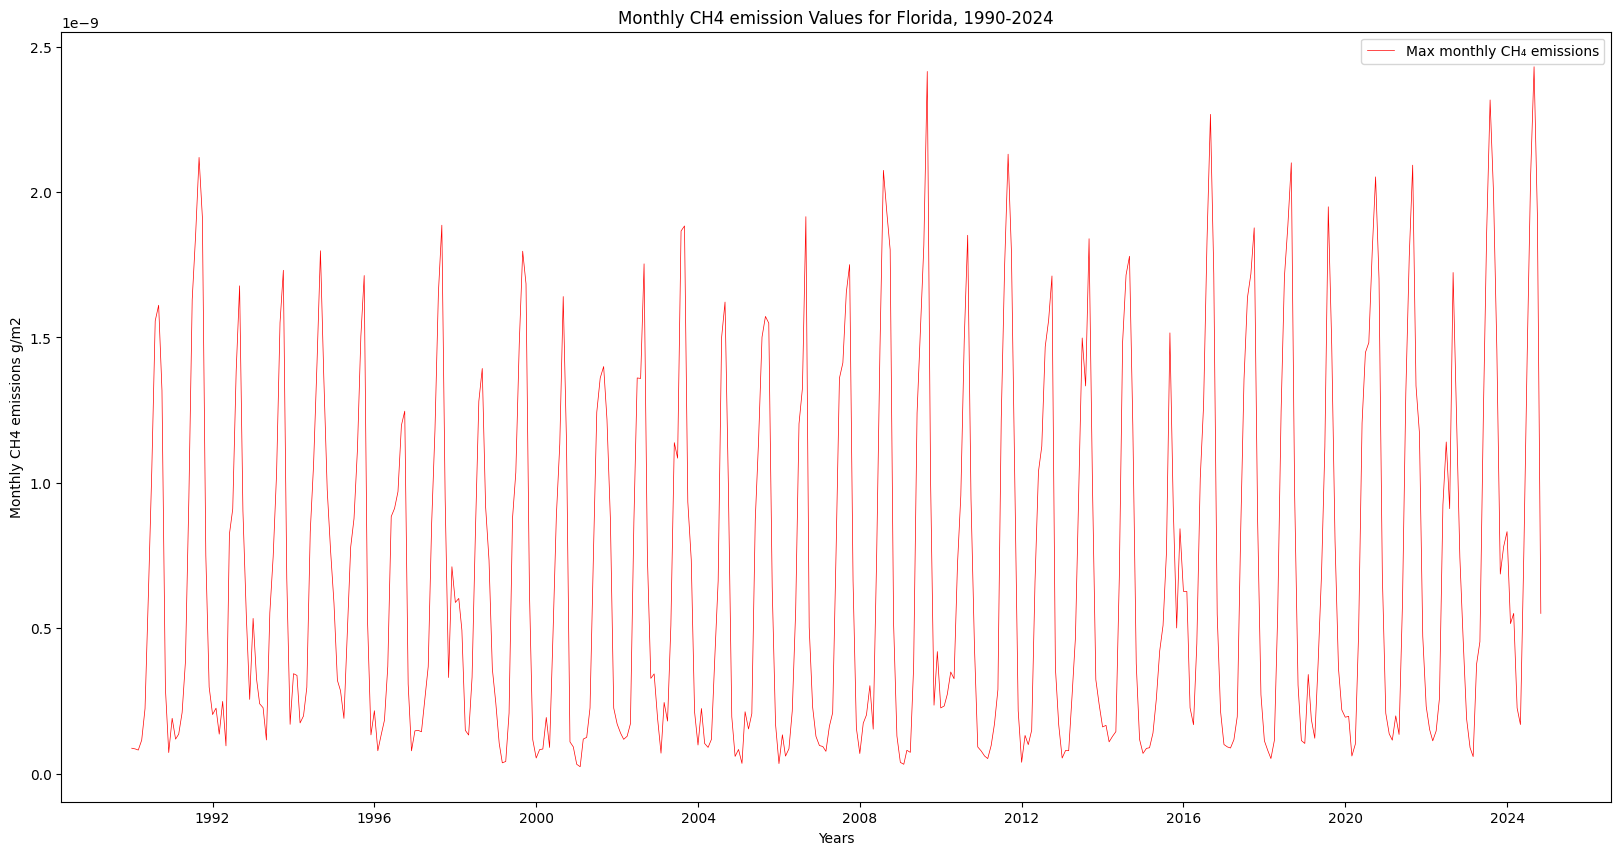

In [47]:
# Determine the width and height of the plot using the 'matplotlib' library
# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(20, 10))

# Plot the time series
plt.plot(
    df["date"], # X-axis: date
    df["max"], # Y-axis: CH₄ value
    color="red", # Line color
    linestyle="-", # Line style
    linewidth=0.5, # Line width
    label="Max monthly CH₄ emissions", # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("Monthly CH4 emissions g/m2")

# Insert title for the plot
plt.title("Monthly CH4 emission Values for Florida, 1990-2024")

## Summary

In this notebook we have successfully completed the following steps for the STAC collection for the Monthly Wetland Methane Emissions, LPJ-EOSIM Model data:
1.  Install and import the necessary libraries
2.  Fetch the collection from STAC collections using the appropriate endpoints
3.  Count the number of existing granules within the collection
4.  Map and compare the CH4 levels over the Texas region for two distinctive years
5.  Create a table that displays the minimum, maximum, and sum of the CH4 levels for a specified region
6.  Generate a time-series graph of the CH4 levels for a specified region

If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform).